In [81]:
import csv
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.linalg import null_space
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
from transforms3d.axangles import axangle2aff

import visualize
from run import estimate

%matplotlib inline


In [82]:
def compute_crop(h, w, h_ratio=0.5, w_ratio=0.4):
    return int((1 - h_ratio) / 2 * h), int((1 + h_ratio) / 2 * h), int((1 - w_ratio) / 2 * w), int((1 + w_ratio) / 2 * w)


def read_inputs(obj_no, f1, f2):
    fname1 = f'/home/slin/data/al/articulated_motion/microwave/img{obj_no:02}_{f1:04}.png'
    fname2 = f'/home/slin/data/al/articulated_motion/microwave/img{obj_no:02}_{f2:04}.png'
    img1 = plt.imread(fname1)[..., :3]  # shape=(1080, 1920, 3), dtype=float32
    img2 = plt.imread(fname2)[..., :3]
    ten1 = torch.from_numpy(img1.copy()).permute(2, 0, 1)
    ten2 = torch.from_numpy(img2.copy()).permute(2, 0, 1)
    top, _, left, _ = compute_crop(*img1.shape[:2])
    offset = np.array([top, left])
    return img1, img2, ten1, ten2, offset


def estimate_flows(ten1, ten2):
    flow12 = estimate(ten1, ten2)
    flow21 = estimate(ten2, ten1)
    return flow12, flow21


def crop(img, h_ratio=0.5, w_ratio=0.4):
    t, b, l, r = compute_crop(*img.shape[:2], h_ratio, w_ratio)
    return img[t:b, l:r]


def filter_flows(flow12, flow21, img1=None, img2=None):
    def compute_mask(fwd_flow, bwd_flow):
        fwd_flow_norm = torch.linalg.vector_norm(fwd_flow, dim=0)
        mask = fwd_flow_norm > 5
        h, w = fwd_flow.shape[1:]
        x = torch.arange(w, device='cuda')
        y = torch.arange(h, device='cuda')
        X, Y = torch.meshgrid(x, y, indexing='xy')
        XY = torch.dstack((X, Y)).float()
        XY_ = XY + fwd_flow.permute(1, 2, 0)
        grid = XY_ * 2 / torch.tensor([w - 1, h - 1], device='cuda') - 1
        bwd2fwd_flow = torch.nn.functional.grid_sample(bwd_flow.unsqueeze(0), grid.unsqueeze(0), padding_mode='zeros', align_corners=False).squeeze(0)
        mask = torch.logical_and(mask, torch.any(bwd2fwd_flow, dim=0))
        fwd_flow_diff = torch.linalg.vector_norm(fwd_flow + bwd2fwd_flow, dim=0)
        fwd_consist_th = torch.maximum(0.03 * fwd_flow_norm, torch.tensor(0.3))
        mask = torch.logical_and(mask, fwd_flow_diff < fwd_consist_th)
        return mask.cpu().numpy(), XY[mask].cpu().numpy(), XY_[mask].cpu().numpy()
    mask1, pts1, pts2 = compute_mask(flow12, flow21)
    if not (img1 is None or img2 is None):
        mask2 = compute_mask(flow21, flow12)[0]
        flow12 = flow12.permute(1, 2, 0).cpu().numpy()
        flow21 = flow21.permute(1, 2, 0).cpu().numpy()
        viz12 = visualize.flow_to_color(flow12)
        viz21 = visualize.flow_to_color(flow21)
        plt.figure(figsize=(15, 15))
        plt.subplot(3, 2, 1)
        plt.imshow(crop(img1))
        plt.axis('off')
        plt.title('img1')
        plt.subplot(3, 2, 2)
        plt.imshow(crop(img2))
        plt.axis('off')
        plt.title('img2')
        plt.subplot(3, 2, 3)
        plt.imshow(crop(viz12))
        plt.axis('off')
        plt.title('flow12')
        plt.subplot(3, 2, 4)
        plt.imshow(crop(viz21))
        plt.axis('off')
        plt.title('flow21')
        img1 = img1.copy()
        img2 = img2.copy()
        img1[mask1] = np.array([.5, 1, 0])
        img2[mask2] = np.array([.5, 1, 0])
        plt.subplot(3, 2, 5)
        plt.imshow(crop(img1))
        plt.axis('off')
        plt.title('mask1')
        plt.subplot(3, 2, 6)
        plt.imshow(crop(img2))
        plt.axis('off')
        plt.title('mask2')
    return pts1, pts2


def visualize_correspondence(img1, img2, pts1, pts2, offset, m=30):
    n = len(pts1)
    m = min(m, n)
    idx = random.sample(range(n), m)
    matches = np.repeat(np.arange(m).reshape(-1, 1), 2, axis=1)
    plt.figure(figsize=(15, 15))
    plot_matches(plt.gca(), crop(img1), crop(img2), pts1[idx][:, ::-1] - offset, pts2[idx][:, ::-1] - offset, matches, only_matches=True)
    plt.axis('off')
    plt.title(f'showing {m} randomly picked matches out of {n}')
    return offset


def estimate_essential_matrix(K, pts1, pts2, randomize=False, method=1):
    n = len(pts1)
    if randomize:
        idx = random.sample(range(n), n)
        pts1 = pts1[idx]
        pts2 = pts2[idx]

    if method == 1:
        E, mask = cv2.findEssentialMat(pts1, pts2, K, threshold=0.1)
        mask = mask.reshape(-1)==1
    else:
        F, mask = ransac((pts1, pts2),
                         FundamentalMatrixTransform, min_samples=8,
                         residual_threshold=0.03, max_trials=5000,
                         random_state=None if randomize else 0)
        E = K.T @ F.params @ K

    print(f'{np.sum(mask)} out of {n} pts are used to compute E')
    return E, mask


def verify_essential_matrix(E, K_inv, pts1, pts2, mask=None):
    F = K_inv.T @ E @ K_inv
    n = len(pts1)
    errs = []
    for i in range(n):
        pt1 = np.append(pts1[i], 1)
        pt2 = np.append(pts2[i], 1)
        l = F @ pt1
        errs.append(abs(pt2.T @ l) / np.sqrt(l[0]**2 + l[1]**2))
    errs = np.array(errs)
    print(f'err mean: {np.mean(errs):.3f}')
    print(f'err std: {np.std(errs):.3f}')
    if mask is not None:
        masked_errs = errs[mask]
        print(f'masked err mean: {np.mean(masked_errs):.3f}', )
        print(f'masked err std: {np.std(masked_errs):.3f}')


def recover_pose(E, pts1, pts2, K):
    # R1, R2, t_ = cv2.decomposeEssentialMat(E)
    # print('Candidate Rs: ', '\n', R1, '\n', R2)
    # print('Candidate ts: ', '\n', t_, '\n', -t_)
    # P1 = np.hstack((K, np.zeros((3, 1))))
    # n = len(pts1)
    # votes = {}
    # for i, R in enumerate([R1, R2]):
    #     for j, t in enumerate([t_, -t_]):
    #         T = np.hstack((R, t))
    #         P2 = K @ T
    #         for k in range(n):
    #             pt1 = pts1[k][:, None]
    #             pt2 = pts2[k][:, None]
    #             p1 = cv2.triangulatePoints(P1, P2, pt1, pt2)
    #             p1 /= p1[3, 0]
    #             p2 = T @ p1
    #             if p1[2, 0] > 0 and p2[2, 0] > 0:
    #                 votes[(i, j)] = votes.get((i, j), 0) + 1
    # print(votes)

    m, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    print(f'{m} out of {len(pts1)} pts pass the cheirality check')
    return R, t


def compute_point_axis(R, t, rcond=None):
    # Rx + t = x, x is a point in the camere's coordinate frame
    # (I-R)x = t
    A = np.identity(3) - R
    p, _, _, s = np.linalg.lstsq(A, t, rcond=rcond)   # point
    print('rcond: ', s[2] / s[0])
    l = null_space(A, rcond=rcond)  # axis
    p = np.append(p, 1)
    l = np.append(l, 0)
    return p, l


def plot_line(img, title, p, l, K, T=None):
    if T is None:
        T = np.eye(4)
    p = K @ (T @ p)[:3]
    l = K @ (T @ l)[:3]
    p1 = p[:2] / p[2]
    p2 = p + l
    p2 = p2[:2] / p2[2]
    p = p1
    l = p2 - p1
    l /= np.linalg.norm(l)
    h, w = img.shape[:2]
    px, py = p
    lx, ly = l
    k1, k2 = sorted([-px / lx, -py / ly, (w - px) / lx, (h - py) / ly])[1:3]
    p1 = p + k1 * l
    p2 = p + k2 * l

    img = cv2.line((img * 255).astype(np.uint8), p1.reshape(-1).astype(int), p2.reshape(-1).astype(int), 0, thickness=3)
    plt.figure(figsize=(10, 10))
    plt.imshow(crop(img))
    plt.axis('off')
    plt.title(title)


def xpmat(v):
    v = v.reshape(-1)
    return np.cross(v, np.eye(len(v))).T


4525 out of 25415 pts are used to compute E
err mean: 0.301
err std: 0.837
masked err mean: 0.021
masked err std: 0.013
4525 out of 4525 pts pass the cheirality check
rcond:  5.331075640392457e-16


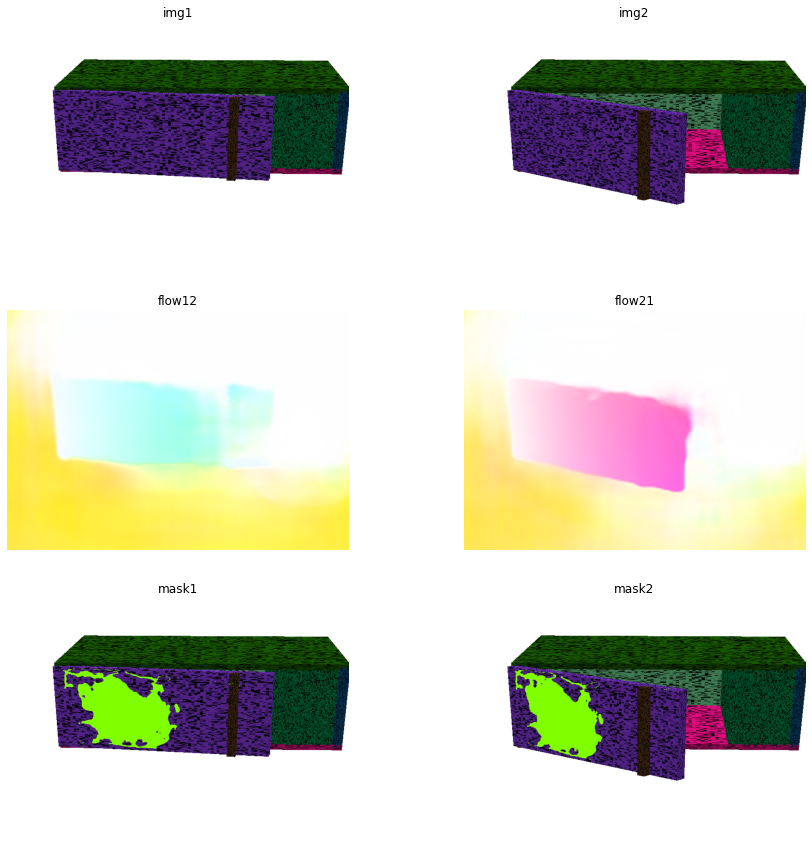

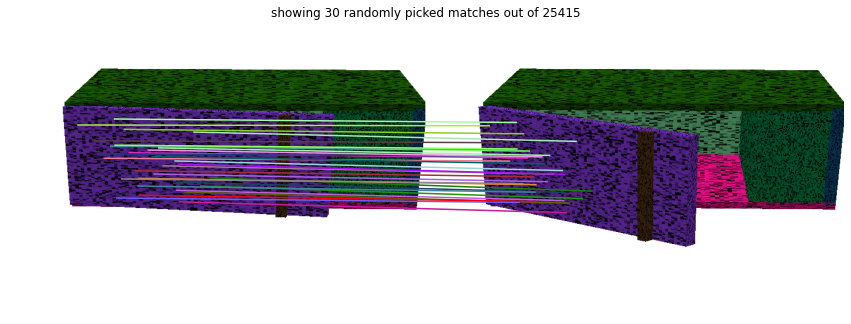

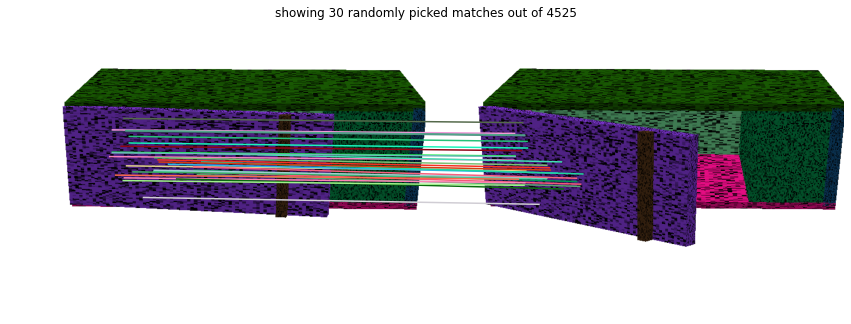

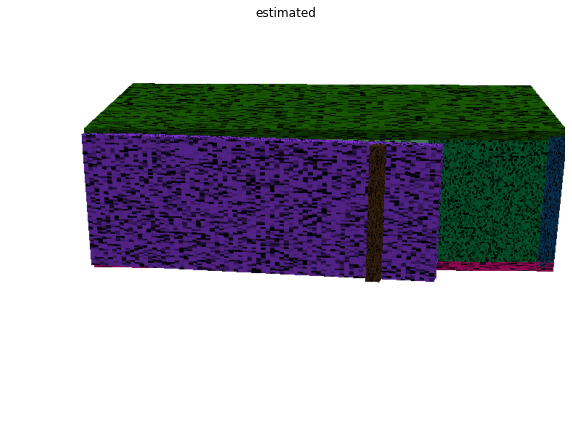

In [83]:
obj_no = 2
f1 = 5
f2 = 19
img1, img2, ten1, ten2, offset = read_inputs(obj_no, f1, f2)
flow12, flow21 = estimate_flows(ten1, ten2)
pts1, pts2 = filter_flows(flow12, flow21, img1, img2)
visualize_correspondence(img1, img2, pts1, pts2, offset)
K = np.load('/home/slin/data/al/articulated_motion/microwave/cam_intrinsics.npy')
K_inv = np.linalg.inv(K)
E, mask = estimate_essential_matrix(K, pts1, pts2, method=2)
verify_essential_matrix(E, K_inv, pts1, pts2, mask=mask)
pts1_ = pts1[mask]
pts2_ = pts2[mask]
visualize_correspondence(img1, img2, pts1_, pts2_, offset)
R, t = recover_pose(E, pts1_, pts2_, K)
p, l = compute_point_axis(R, t, rcond=1e-12)
plot_line(img1, 'estimated', p, l, K)


In [84]:
with open('/home/slin/data/al/articulated_motion/microwave/labels.csv') as f:
    reader = csv.reader(f)
    for _, _, str_id, l1, l2, l3, p1, p2, p3, v in reader:
        if str_id == f'{obj_no:02}_{f1:04}':
            v1 = float(v)
        elif str_id == f'{obj_no:02}_{f2:04}':
            v2 = float(v)
            break
T = np.load(f'/home/slin/data/al/articulated_motion/microwave/cam_extrinsics{obj_no:02}.npy')[0]
T = np.vstack((T, [0, 0, 0, 1]))

gt_p_w = np.array([p1, p2, p3, 1], dtype=float)
gt_l_w = np.array([l1, l2, l3, 0], dtype=float)
gt_p = T @ gt_p_w
gt_l = T @ gt_l_w

A = axangle2aff(gt_l[:3], v2 - v1, gt_p)
gt_R = A[:3, :3]
gt_t = A[:3, 3]
gt_E = xpmat(gt_t) @ gt_R

depth1 = torch.load(f'/home/slin/data/al/articulated_motion/microwave/depth{obj_no:02}_{f1:04}.pt')
gt_pts2 = []
for pt1 in pts1:
    pt1 = np.append(pt1, 1).astype(int)
    d1 = depth1[pt1[1], pt1[0]]
    p1 = d1 * K_inv @ pt1
    p2 = gt_R @ p1 + gt_t
    pt2 = K @ p2 / p2[2]
    gt_pts2.append(pt2)
gt_pts2 = np.array(gt_pts2)[:, :2]
gt_pts2_ = gt_pts2[mask]


25415 out of 25415 pts are used to compute E
err mean: 0.000
err std: 0.000
25415 out of 25415 pts pass the cheirality check
rcond:  4.9305653373661744e-18


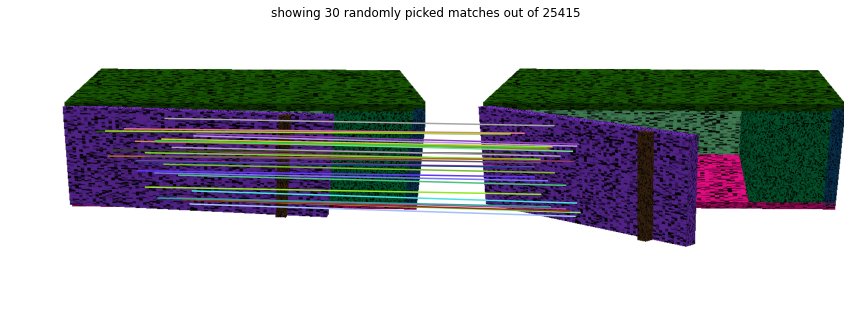

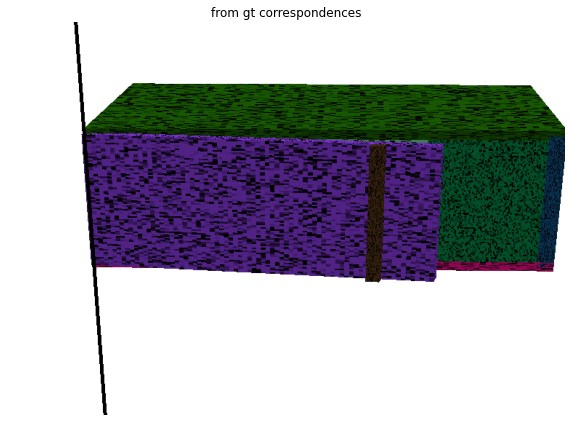

In [76]:
E, _ = estimate_essential_matrix(K, pts1, gt_pts2)
verify_essential_matrix(E, K_inv, pts1, gt_pts2)
visualize_correspondence(img1, img2, pts1, gt_pts2, offset)
R, t = recover_pose(E, pts1, gt_pts2, K)
p, l = compute_point_axis(R, t, rcond=1e-12)
plot_line(img1, 'from gt correspondences', p, l, K)


correspondence err stats (all pts passing flow consistency test):
	number: 25415
	mean: 0.6851117743862859
	std: 2.110051051908831
	min: 0.002695666291717732
	max: 89.24356593582228
correspondence err stats (only pts used in computing E):
	number: 4525
	mean: 0.4898339901006014
	std: 0.28678835062177493
	min: 0.006689621685182255
	max: 1.4531354170026387


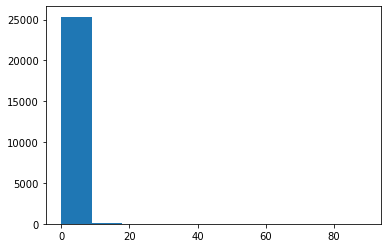

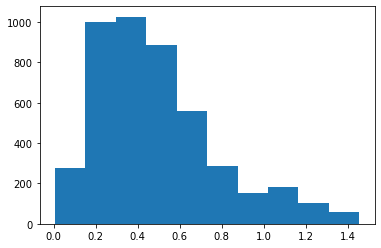

In [85]:
errs = np.linalg.norm(gt_pts2 - pts2, axis=1)
print('correspondence err stats (all pts passing flow consistency test):')
print(f'\tnumber: {len(errs)}')
print(f'\tmean: {np.mean(errs)}')
print(f'\tstd: {np.std(errs)}')
print(f'\tmin: {np.min(errs)}')
print(f'\tmax: {np.max(errs)}')
plt.figure()
plt.hist(errs);


errs = np.linalg.norm(gt_pts2_ - pts2_, axis=1)
print('correspondence err stats (only pts used in computing E):')
print(f'\tnumber: {len(errs)}')
print(f'\tmean: {np.mean(errs)}')
print(f'\tstd: {np.std(errs)}')
print(f'\tmin: {np.min(errs)}')
print(f'\tmax: {np.max(errs)}')
plt.figure()
plt.hist(errs);


[[797.08514 500.94623]
 [837.5175  511.6909 ]
 [736.8819  516.2855 ]
 [812.8458  532.4582 ]
 [812.1009  533.39087]
 [804.69073 539.66046]
 [805.4476  539.7402 ]
 [757.17474 541.91223]
 [757.94714 544.02295]
 [822.3866  554.1375 ]
 [737.85944 559.59717]]
[[797.08054998 500.93825158]
 [837.50608915 511.68151729]
 [736.86771059 516.28568233]
 [812.8377186  532.45123414]
 [812.10075367 533.38750161]
 [804.69441105 539.65345867]
 [805.451956   539.74586106]
 [757.17124903 541.91793571]
 [757.95328914 544.03459816]
 [822.4004523  554.14162121]
 [737.85945231 559.59447235]]
11 out of 11 pts are used to compute E
err mean: 0.006
err std: 0.008
9 out of 11 pts pass the cheirality check
rcond:  5.228841599410616e-16


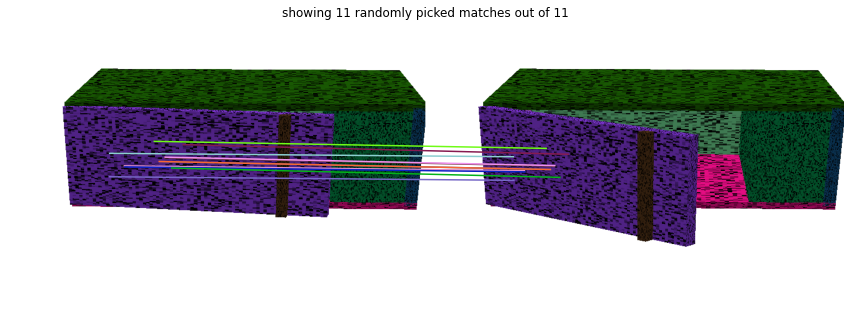

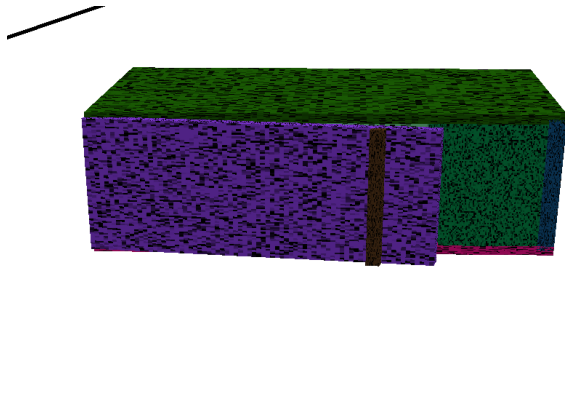

In [95]:
errs = np.linalg.norm(gt_pts2 - pts2, axis=1)
mask = errs < .015
pts1_ = pts1[mask]
pts2_ = pts2[mask]
E, mask = estimate_essential_matrix(K, pts1_, pts2_, randomize=True, method=2)
verify_essential_matrix(E, K_inv, pts1_, pts2_)
pts1_ = pts1_[mask]
pts2_ = pts2_[mask]
visualize_correspondence(img1, img2, pts1_, pts2_, offset)
R, t = recover_pose(E, pts1_, pts2_, K)
p, l = compute_point_axis(R, t, rcond=1e-12)
plot_line(img1, '', p, l, K)
